# 3D DEEP LEARNING - HARDCORE VERSION 💀

Welcome to the 3D Deep Learning Workshop!

In this workshop, you'll learn to:
* Process a 3D Point Cloud Dataset
* Visualize the Dataset in 3D
* Build a 3D Deep Learning Model
* Test on new data

The code has been adapted from Intel's version for education purpose: https://github.com/intel-isl/Open3D-PointNet


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremy26/3d-deep-learning/blob/main/3D%20Deep%20Learning/3D_DL_Starter_Hardcore.ipynb)

## Imports
We'll need a few things to get started:
* Open3D: A Point Cloud Library; we'll use it for Visualization - We use version 12
* PyTorch: A Deep Learning Library - We Use version 1.7
* All the other usual libraries (numpy, matplotlib, random, ...)

In [ ]:
# Do this if you don't have Open3D
# !pip install open3d==0.12.0 # Version 12
# !pip install progressbar

In [1]:
# Usual Imports
from __future__ import print_function
import os
import random
from random import randrange
from IPython.display import clear_output
from PIL import Image
import os.path
import errno
import json
import codecs
import numpy as np
import progressbar
import sys
import matplotlib.pyplot as plt

# Open3D Imports
import open3d as o3
print(o3.__version__)
# from open3d import JVisualizer # Useful for Jupyter Notebook Visualization
from open3d.web_visualizer import draw

# PyTorch Imports
import torch #Version 1.7.0 is the one used in the course
print(torch.__version__)
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from torch.autograd import Variable
import torch.nn.functional as F
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0.16.0
[Open3D INFO] Resetting default logger to print to terminal.
1.11.0


# Dataset

We are going to work with the ShapeNet Dataset.<p>
It's coming from Standford and will allow us to do both Classification and Segmentation.<p>
Here's an X-Wing from the DataSet:
![XWING](https://www.shapenet.org/shapenet/screenshots/models/3dw/d/d/9/e/c/e07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356-5.png)

## Download the Dataset

In [2]:
#Run this only if you don't already have the Dataset
# !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
# !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
# !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

In [2]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Preprocess the Dataset

In [3]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = 'shapenetcore_partanno_segmentation_benchmark_v0'

In [4]:
class PartDataset(torch.utils.data.Dataset):
    """
    This preprocesses the dataset.
    TODO: This part has already been coded for you and is functional.
    TODO: But there is still an assignment
    TODO: Understand it well enough so you can add a visualization of the segmentation image and return it.
    """
    def __init__(self, root, npoints=2500, classification=False, class_choice=None, train=True, image=False):
        '''
        Assign the parameters: number of points, root folder, category file, image, classification.
        '''
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.image = image
        self.classification = classification
        '''
        Open the Category File and Map Folders to Categories
        '''
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        
        '''
        Select categories from the dataset. 
        ex: Call in parameters "class_choice=["Airplane"].
        '''
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        
        '''
        For every item in a specific category, assign the point, segmentation, and image.
        Basically, read the dataset and store the labels.
        '''
        self.meta = {}        
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            # TODO: Modify below
            dir_seg_img = os.path.join(self.root, self.cat[item], 'seg_img')
            #print(dir_point, dir_seg)
            

            # get split based on whether we are training or testing (no validation?)
            # we should try to use the .json files to get the splits
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            #print(os.path.basename(fns))
            for fn in fns: # FOR EVERY POINT CLOUD FILE
                token = (os.path.splitext(os.path.basename(fn))[0])
                # TODO:Modify below
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), 
                                        os.path.join(dir_seg, token + '.seg'),
                                        os.path.join(dir_seg_img, token + '.png')))

        '''
        Create a Variable where you have (item, points, segmentation points, segmentation image)
        '''
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                # TODO: Modify below
                self.datapath.append((item, fn[0], fn[1], fn[2]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        #print(self.classes)
        
        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                # TODO: Modify below
                l = len(np.unique(np.loadtxt(self.datapath[i][2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)

    def __getitem__(self, index):
        '''
        This will be used to pick a specific element from the dataset.
        self.datapath is the dataset.
        Each element is under format "class, points, segmentation labels, segmentation image"
        '''
        # Get one Element
        fn = self.datapath[index]
        #print(fn)
        
        # get its Class
        cls = self.classes[fn[0]]
        #print(cls)
        
        # Read the Point Cloud
        point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)
        
        # Read the Segmentation Data
        seg = np.loadtxt(fn[2]).astype(np.int64)

        #print(point_set.shape, seg.shape)
        
        # TODO: Read the Segmentation Image
        # image = np.array(Image.open(fn[3]))
        image = Image.open(fn[3])
        # image = read_image(fn[3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        
        #resample
        point_set = point_set[choice, :]        
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        
        if self.classification:
            if self.image:
                return point_set, cls, image
            else:
                return point_set, cls

        else:
            if self.image:
                return point_set, seg, image
            else:
                return point_set, seg

    def __len__(self):
        return len(self.datapath)

In [5]:
# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

## Visualize the Dataset with Open3D

In [6]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

Number of objects 15990
----------
Point Cloud Caracteristics:
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
----------
Point Cloud
tensor([[-0.1069,  0.1909,  0.1104],
        [ 0.1036,  0.1909, -0.2100],
        [-0.0183,  0.1909,  0.1917],
        ...,
        [ 0.0772,  0.1909,  0.2562],
        [ 0.0463,  0.1909,  0.2339],
        [ 0.1097, -0.0161,  0.4052]])
----------
Label on Part Segmentation
tensor([3, 1, 1,  ..., 1, 1, 2])
----------
Label on Classification
Table


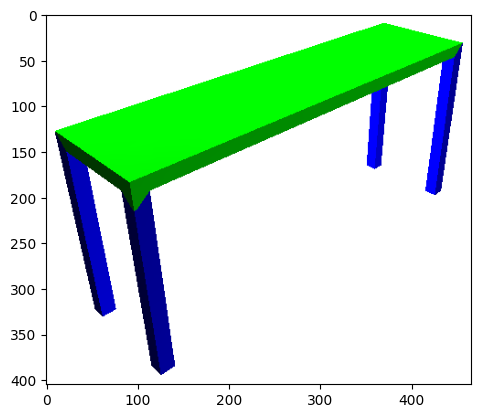

In [15]:
# Load the ShapeNet Dataset
# Default parameters for PartDataset: npoints = 2500, classification = False, class_choice = None, train = True, image=False

#TODO: Get a Dataset for segmentation and with the image you got
d = PartDataset(DATA_FOLDER, npoints=2500, classification=False, class_choice=None, train=True, image=True)
print("Number of objects",len(d))
print('----------')

idx = random.randint(0,len(d))
ps, seg, img = d[idx]

print("Point Cloud Caracteristics:")
print(ps.size(), ps.type(), seg.size(),seg.type())
print('----------')
print("Point Cloud")
print(ps)
print('----------')
print("Label on Part Segmentation")
print(seg)
print('----------')

# #TODO: Get a Dataset for Classification with the same index and without the image
d = PartDataset(DATA_FOLDER, npoints=2500, classification=True, class_choice=None, train=True, image=False)
ps2, class_ = d[idx]

print("Label on Classification")
classes_dict_list = list(classes_dict)
print(classes_dict_list[class_.item()])

plt.imshow(np.asarray(img))

In [16]:
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

# test_vis.add_geometry(test_cloud)
# test_vis.show()

draw(test_cloud)

WebVisualizer(window_uid='window_5')

# 3D Deep Learning Model: PointNet

## Build the Model: PointNet

**The model is PointNet.**<p>
![PointNet](https://d3i71xaburhd42.cloudfront.net/c3b6a072288e134f5ae6afe3eebc970ffb65cb68/3-Figure2-1.png)

It's coming from the paper: https://arxiv.org/pdf/1612.00593.pdf

### Build the T-Net

In this part, you need to re-implement the image you see above!<p>
Watch solution if you're stuck!

In [70]:
class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, dim, num_points=2500):
        super(STN3d, self).__init__()
        #TODO: Implement the functions you'll need

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        # TODO: Forward function
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).squeeze()

        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x

sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d(dim=3)
out = trans(sim_data)
# print("Output Size must be [32, 3, 3]")
print('stn', out.size())


stn torch.Size([32, 3, 3])


### Build the Feature T-Net + MLP

In [77]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points=2500, global_feat=True):
        super(PointNetfeat, self).__init__()

        self.global_feat = global_feat

        # Spatial Transformer Networks (T-nets)
        self.stn1 = STN3d(dim=3, num_points=num_points)
        self.stn2 = STN3d(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, 1024, kernel_size=1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

    
    def forward(self, x):
        print(x.shape)
        
        # pass through first Tnet to get transform matrix
        trans1 = self.stn1(x)

        # perform first transformation
        x = torch.bmm(x.transpose(2, 1), trans1).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        print(x.shape)
        
        # get feature transform
        trans2 = self.stn2(x)

        # perform second transformation
        x = torch.bmm(x.transpose(2, 1), trans2).transpose(2, 1)

        # store point features 
        point_features = x.clone()

        print('point_features: ', point_features.shape)

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector
        x = self.max_pool(x).squeeze()
        print(x.shape)

        if self.global_feat:
            return x, trans1
        else:
            # return concatenated local and global features for segmentation network
            return torch.cat(point_features, x), trans1


In [78]:
pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

torch.Size([32, 3, 2500])
torch.Size([32, 64, 2500])
point_features:  torch.Size([32, 64, 2500])
torch.Size([32, 1024])


TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


### Build the Classification Head

In [35]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        pass
    def forward(self, x):
        pass

In [36]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k = 5)
out, _ = cls(sim_data)
print('class', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


### Build the Segmentation Head

In [37]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        pass

    def forward(self, x):
        pass

In [ ]:
seg = PointNetDenseCls(k = 3)
print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

## Train the Model for classification and segmentation

In [40]:
# TODO: Define Hyperparameters
batchSize = 
num_points = 
workers =
nepoch = 
outf="cls" #Out folder, saving each epoch

In [ ]:
# DATASET & DATA LOADER

# Train Dataset & DataLoader
dataset = 
dataloader = 

# Test Dataset & DataLoader
test_dataset = 
testdataloader = 

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())

classifier = # TODO: Create a classifier

optimizer = #TODO: DEFINE OPTIMIZERS
if torch.cuda.is_available():
    classifier.cuda()

num_batch = # What is the number of batch?

# TRAIN ON EPOCHS
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        """
        Get Points & Classification Label
        """
        points = # Get the points
        
        if torch.cuda.is_available():
            points, target = points.cuda(), target.cuda()
        
        # TODO: Zero Grad
        
        # TODO: Train
        classifier = 
        pred, _ = 
        # TODO: Define NLL Loss and Backpropagate
        loss = 

        pred_choice = # get the prediction
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, loss.item(),correct.item() / float(batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            points, target = Variable(points), Variable(target[:,0])
            points = points.transpose(2,1)
            if torch.cuda.is_available():
                points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch))

In [45]:
NUM_POINTS = 
MODEL_PATH = 

classifier = #todo: # Create the classification network from pre-trained model

if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

PointNetCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=10000, stride=10000, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

# Visualize the output

JVisualizer with 1 geometries

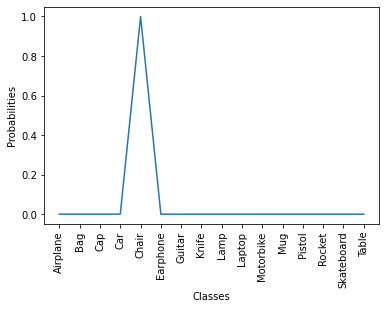

KeyboardInterrupt: Interrupted by user

In [49]:
# Three.js based visualizer
visualizer = JVisualizer()

test_dataset_seg = #Get a dataset for testing

# Basic inference and visualization loop
MAX_SAMPLES = 15

for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    visualizer.clear()
    clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    visualizer.add_geometry(cloud)
    visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))